In [35]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [2]:
df_train = pd.read_csv('../kaggle-quora/data/train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Duplicate pairs: 36.92%
Total num. of unique questions in the training data: 537933
Number of questions that appear multiple times: 111780


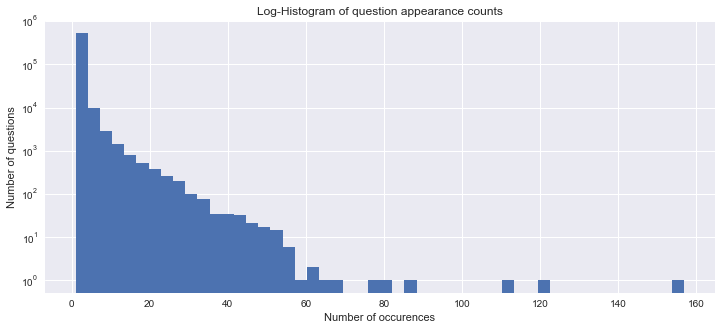

In [3]:
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total num. of unique questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}' \
      .format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences')
plt.ylabel('Number of questions')
plt.show()

In [4]:
df_test = pd.read_csv('../kaggle-quora/data/test.csv')
print(df_test.head())
print(df_test.tail())

   test_id                                          question1  \
0        0  How does the Surface Pro himself 4 compare wit...   
1        1  Should I have a hair transplant at age 24? How...   
2        2  What but is the best way to send money from Ch...   
3        3                        Which food not emulsifiers?   
4        4                   How "aberystwyth" start reading?   

                                           question2  
0  Why did Microsoft choose core m3 and not core ...  
1        How much cost does hair transplant require?  
2                      What you send money to China?  
3                                  What foods fibre?  
4                     How their can I start reading?  
         test_id                                          question1  \
2345791  2345791  How do Peaks (TV series): Why did Leland kill ...   
2345792  2345792  What does be "in transit" mean on FedEx tracking?   
2345793  2345793  What are some famous Romanian drinks (alcoholi..

In [5]:
print('Total number of question pairs for testing: {}'.format(len(df_test)))

Total number of question pairs for testing: 2345796


mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.62 max-train 1169.00 max-test 1176.00


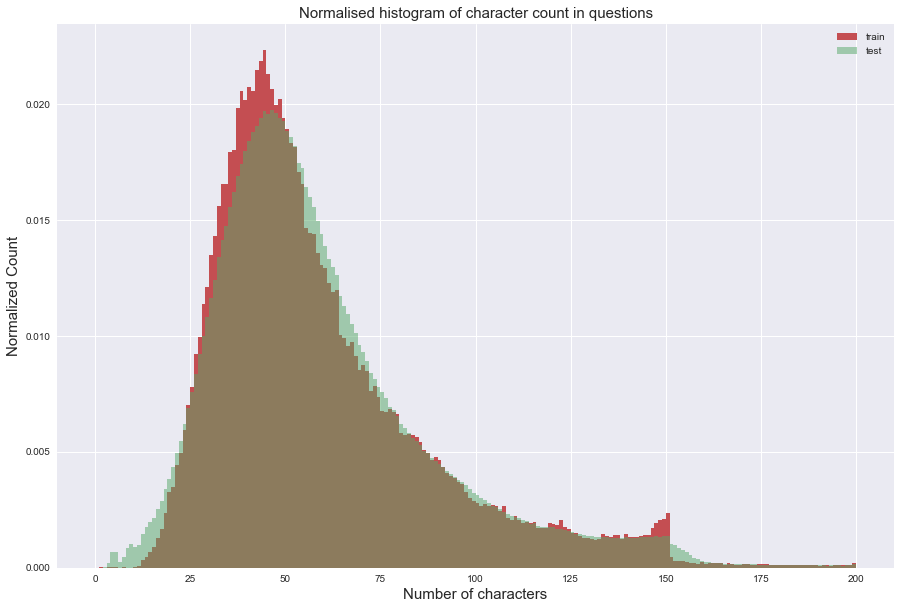

In [7]:
pal = sns.color_palette()

train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train_char = train_qs.apply(len)
dist_test_char = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train_char, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test_char, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Normalized Count', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train_char.mean(), 
                          dist_train_char.std(), dist_test_char.mean(), dist_test_char.std(), dist_train_char.max(), dist_test_char.max()))

mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


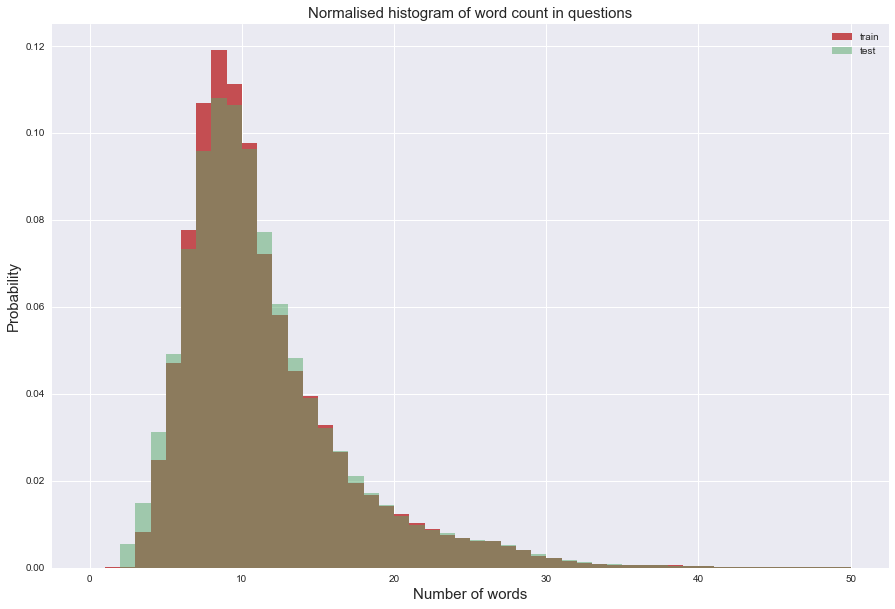

In [8]:
dist_train_words = train_qs.apply(lambda x: len(x.split(' ')))
dist_test_words = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train_words, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test_words, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train_words.mean(), 
                          dist_train_words.std(), dist_test_words.mean(), dist_test_words.std(), dist_train_words.max(), dist_test_words.max()))

In [9]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

ModuleNotFoundError: No module named 'wordcloud'

# A simple word share to compare questions 1 and questions 2

In [10]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

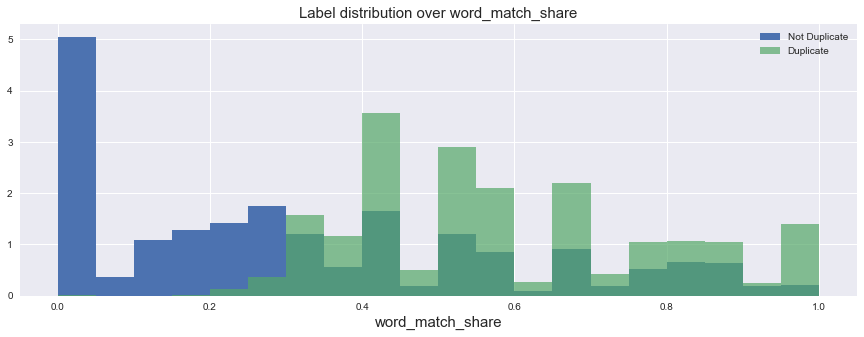

In [11]:
plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [12]:
from collections import Counter

words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
counts

Counter({'what': 310963,
         'is': 268849,
         'the': 376234,
         'step': 594,
         'by': 17071,
         'guide': 252,
         'to': 204067,
         'invest': 1572,
         'in': 194724,
         'share': 1122,
         'market': 1396,
         'india?': 16164,
         'story': 1122,
         'of': 158912,
         'kohinoor': 20,
         '(koh-i-noor)': 6,
         'diamond?': 33,
         'how': 219019,
         'can': 113819,
         'i': 213185,
         'increase': 4163,
         'speed': 1706,
         'my': 70759,
         'internet': 1568,
         'connection': 297,
         'while': 4488,
         'using': 6081,
         'a': 210233,
         'vpn?': 72,
         'why': 75548,
         'am': 12571,
         'mentally': 245,
         'very': 2982,
         'lonely?': 118,
         'solve': 1448,
         'it?': 6778,
         'which': 43767,
         'one': 17891,
         'dissolve': 65,
         'water': 2770,
         'quikly': 3,
         'sugar,'

# Using custom made TF-IDF.

In [13]:
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

In [14]:
weights = {word: get_weight(count) for word, count in counts.items()}
weights

{'what': 3.115623919267953e-06,
 'is': 3.5861702928825277e-06,
 'the': 2.5891040146646852e-06,
 'step': 9.439305267132339e-05,
 'by': 3.693989878467733e-05,
 'guide': 9.754194303550527e-05,
 'to': 4.671434644293609e-06,
 'invest': 8.641548565502938e-05,
 'in': 4.884625153865692e-06,
 'share': 8.991188635137565e-05,
 'market': 8.775008775008775e-05,
 'india?': 3.822045558783061e-05,
 'story': 8.991188635137565e-05,
 'of': 5.920242493132519e-06,
 'kohinoor': 9.98003992015968e-05,
 '(koh-i-noor)': 9.994003597841295e-05,
 'diamond?': 9.96710854181202e-05,
 'how': 4.366449945201053e-06,
 'can': 8.076304928968897e-06,
 'i': 4.4805878531263305e-06,
 'increase': 7.060650992021465e-05,
 'speed': 8.542627712284299e-05,
 'my': 1.2382520833591302e-05,
 'internet': 8.644536652835408e-05,
 'connection': 9.711566475672526e-05,
 'while': 6.902263942573165e-05,
 'using': 6.218518748834027e-05,
 'a': 4.540645588989843e-06,
 'vpn?': 9.928514694201747e-05,
 'why': 1.1689343994015055e-05,
 'am': 4.43046386

In [15]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('シ', 9.998000399920016e-05),
 ('し?', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05),
 ('109?', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('fulfill?', 9.998000399920016e-05)]

In [16]:
len(weights)

201102

In [17]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] \
                   + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + \
                    [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

In [18]:
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
tfidf_train_word_match

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


0         0.772164
1         0.361758
2         0.355191
3         0.000000
4         0.000000
5         0.510771
6         0.000000
7         0.645836
8         0.396755
9         0.503203
10        0.000000
11        0.654071
12        1.000000
13        0.536457
14        0.804625
15        0.307390
16        0.536711
17        0.000000
18        0.532416
19        0.488021
20        0.589277
21        0.000000
22        0.652711
23        0.000000
24        0.000000
25        0.720855
26        0.353365
27        0.000000
28        0.762706
29        0.527833
            ...   
404260    0.382804
404261    0.578849
404262    0.668261
404263    0.330545
404264    0.249702
404265    0.346612
404266    0.166106
404267    0.826632
404268    0.000000
404269    0.755497
404270    0.228984
404271    0.000000
404272    0.382578
404273    0.583512
404274    0.368606
404275    0.000000
404276    0.000000
404277    0.000000
404278    0.259237
404279    0.369876
404280    0.904533
404281    0.

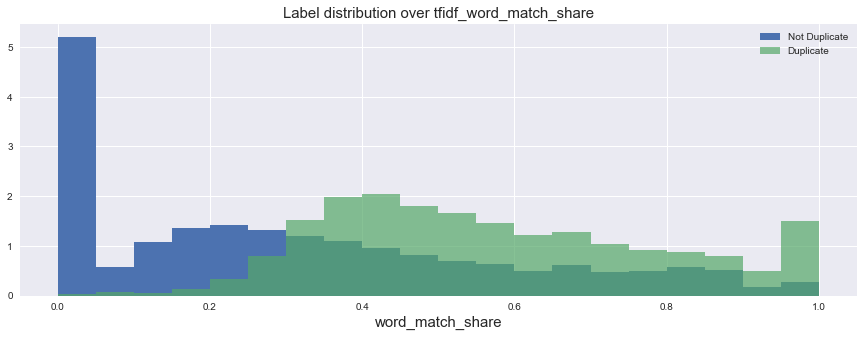

In [19]:
plt.figure(figsize=(15, 5))
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [20]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.780553200628
   TFIDF AUC: 0.77056466105


# Using sklearn TF-IDF and do some pre-cleaning.

In [21]:
import re

def questions_to_words( raw_review ):
    ''' Convert questions to words using regular expresssion, \
    removing stopwrods, and keep only alphabets'''

    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

In [22]:
train_qs.shape[0]

808580

In [23]:
print("Cleaning and parsing the training set movie reviews...\n")
clean_train_reviews = []
for i in range( 0, train_qs.shape[0]):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print("Review %d of %d\n" % ( i+1, train_qs.shape[0] ))
    clean_train_reviews.append( questions_to_words( train_qs[i] ))

Cleaning and parsing the training set movie reviews...

Review 1000 of 808580

Review 2000 of 808580

Review 3000 of 808580

Review 4000 of 808580

Review 5000 of 808580

Review 6000 of 808580

Review 7000 of 808580

Review 8000 of 808580

Review 9000 of 808580

Review 10000 of 808580

Review 11000 of 808580

Review 12000 of 808580

Review 13000 of 808580

Review 14000 of 808580

Review 15000 of 808580

Review 16000 of 808580

Review 17000 of 808580

Review 18000 of 808580

Review 19000 of 808580

Review 20000 of 808580

Review 21000 of 808580

Review 22000 of 808580

Review 23000 of 808580

Review 24000 of 808580

Review 25000 of 808580

Review 26000 of 808580

Review 27000 of 808580

Review 28000 of 808580

Review 29000 of 808580

Review 30000 of 808580

Review 31000 of 808580

Review 32000 of 808580

Review 33000 of 808580

Review 34000 of 808580

Review 35000 of 808580

Review 36000 of 808580

Review 37000 of 808580

Review 38000 of 808580

Review 39000 of 808580

Review 40000 of 8

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_df = 0.9, \
                             min_df = 2, \
                             max_features = 200000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# train_data_features = train_data_features.toarray()
train_data_features

Creating the bag of words...



<808580x48595 sparse matrix of type '<class 'numpy.float64'>'
	with 4191515 stored elements in Compressed Sparse Row format>

In [25]:
sk_weights = vectorizer.vocabulary_
sk_weights

{'step': 41203,
 'guide': 18319,
 'invest': 21877,
 'share': 38888,
 'market': 26188,
 'india': 21042,
 'story': 41382,
 'kohinoor': 23699,
 'koh': 23698,
 'noor': 29575,
 'diamond': 11701,
 'increase': 20982,
 'speed': 40597,
 'internet': 21699,
 'connection': 8978,
 'using': 45843,
 'vpn': 46799,
 'mentally': 26870,
 'lonely': 25200,
 'solve': 40249,
 'one': 30313,
 'dissolve': 12257,
 'water': 47090,
 'quikly': 34809,
 'sugar': 41852,
 'salt': 37611,
 'methane': 27032,
 'carbon': 6470,
 'di': 11663,
 'oxide': 30986,
 'astrology': 2795,
 'capricorn': 6431,
 'sun': 41933,
 'cap': 6388,
 'moon': 27983,
 'rising': 36876,
 'say': 37923,
 'buy': 6048,
 'tiago': 43608,
 'good': 17791,
 'geologist': 17326,
 'use': 45819,
 'instead': 21515,
 'motorola': 28138,
 'company': 8600,
 'hack': 18491,
 'charter': 7231,
 'dcx': 10695,
 'method': 27036,
 'find': 15763,
 'separation': 38608,
 'slits': 39855,
 'fresnel': 16605,
 'read': 35376,
 'youtube': 48347,
 'comments': 8515,
 'make': 25812,
 'phys

In [26]:
def sklearn_tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    
    shared_weights = [sk_weights.get(w, 0) for w in q1words.keys() if w in q2words] \
                   + [sk_weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [sk_weights.get(w, 0) for w in q1words] + \
                    [sk_weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

In [27]:
sk_tfidf_train_word_match = df_train.apply(sklearn_tfidf_word_match_share, axis=1, raw=True)
sk_tfidf_train_word_match

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


0         0.901830
1         0.191605
2         0.519395
3         0.000000
4         0.000000
5         0.602577
6         0.000000
7         0.000000
8         1.000000
9         0.796954
10        0.000000
11        0.519143
12        1.000000
13        0.880059
14        1.000000
15        0.478724
16        1.000000
17        0.000000
18        0.431667
19        0.662909
20        0.546081
21        0.000000
22        0.070463
23        0.000000
24        0.000000
25        0.947420
26        0.977579
27        0.000000
28        0.847898
29        0.639023
            ...   
404260    0.923715
404261    0.831325
404262    0.521105
404263    0.287301
404264    0.497948
404265    0.358458
404266    0.239410
404267    0.775304
404268    0.000000
404269    0.567428
404270    1.000000
404271    0.000000
404272    0.356448
404273    0.451996
404274    0.408700
404275    0.000000
404276         NaN
404277    0.000000
404278    0.527884
404279    0.182764
404280    0.841192
404281    0.

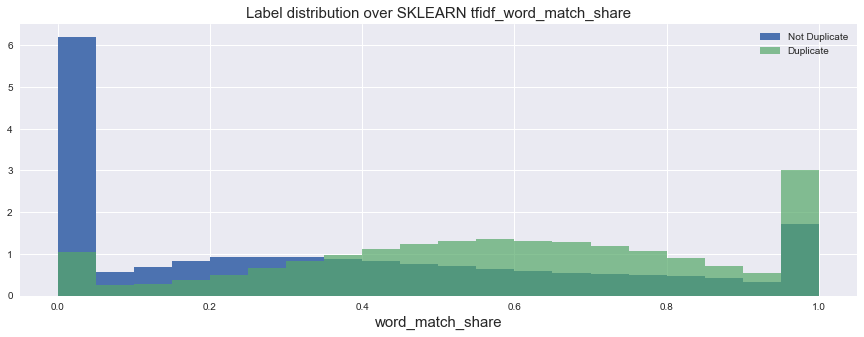

In [28]:
plt.figure(figsize=(15, 5))
plt.hist(sk_tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(sk_tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over SKLEARN tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [29]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))
print('SKLEARN TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], sk_tfidf_train_word_match.fillna(0)))

Original AUC: 0.780553200628
   TFIDF AUC: 0.77056466105
SKLEARN TFIDF AUC: 0.70689963913


# Save the features

In [30]:
features = pd.DataFrame()

features['word_match'] = train_word_match
features['tfidf_word_match'] = tfidf_train_word_match
features['sk_tfidf_word_match'] = sk_tfidf_train_word_match
features.to_csv('./tf_idf_word_share.csv')

# Using shared word + custom tf-idf features + sklearn tf-idf features

In [33]:
%%time

### Step 1: Create dataframe with desired features ###
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()

x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_train['sk_tfidf_word_match'] = sk_tfidf_train_word_match

x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)
x_test['sk_tfidf_word_match'] = df_test.apply(sklearn_tfidf_word_match_share, axis=1, raw=True)

y_train = df_train['is_duplicate'].values

### Step 2: Re-balance the data ###
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -= 1
print('scale: ', scale, ', len(neg_train): ', len(neg_train))
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


scale:  0.2375627456138969 , len(neg_train):  510054
0.19124366100096607
CPU times: user 6min 12s, sys: 2.14 s, total: 6min 14s
Wall time: 6min 17s


In [36]:
%%time

### Step 3: train/validation split ###
# Finally, we split some of the data off for validation
x_train, x_valid, y_train, y_valid = \
    train_test_split(x_train, y_train, test_size=0.2, random_state=4242)
    
### Step 4: xgb training ###
# Params by David Solis
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.11 # Default 0.02
params['max_depth'] = 5 # Default 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.640059	valid-logloss:0.640149
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.423944	valid-logloss:0.424566
[20]	train-logloss:0.375368	valid-logloss:0.376151
[30]	train-logloss:0.361856	valid-logloss:0.362724
[40]	train-logloss:0.357427	valid-logloss:0.358346
[50]	train-logloss:0.355601	valid-logloss:0.356572
[60]	train-logloss:0.354488	valid-logloss:0.355586
[70]	train-logloss:0.353722	valid-logloss:0.35499
[80]	train-logloss:0.353154	valid-logloss:0.35456
[90]	train-logloss:0.352439	valid-logloss:0.354034
[100]	train-logloss:0.351887	valid-logloss:0.353651
[110]	train-logloss:0.351233	valid-logloss:0.353173
[120]	train-logloss:0.35073	valid-logloss:0.352876
[130]	train-logloss:0.350329	valid-logloss:0.352633
[140]	train-logloss:0.349916	valid-logloss:0.352449
[150]	train-logloss:0.349458	valid-logloss:0.352177
[160]	train-logloss:0.349117	va

In [37]:
x_train.head()

,word_match,tfidf_word_match,sk_tfidf_word_match
228120,0.333333,0.288910,0.313414
282596,0.400000,0.195401,0.800521
184291,0.545455,0.581278,0.619937
130333,0.000000,0.000000,0.000000
396840,0.200000,0.173738,0.389156


# Use cross validation to check the performance.

In [38]:
%%time

model_cv = xgb.cv(params, \
                  d_train, \
                  400, \
                  nfold=3, \
                  metrics='logloss', \
                  early_stopping_rounds=50, \
                  verbose_eval=10)

[0]	train-logloss:0.640049+3.37277e-05	test-logloss:0.64009+1.48847e-05
[10]	train-logloss:0.423914+0.000182487	test-logloss:0.424165+0.000180412
[20]	train-logloss:0.375148+0.000219205	test-logloss:0.375644+0.000381704
[30]	train-logloss:0.361521+0.000248972	test-logloss:0.362218+0.00043857
[40]	train-logloss:0.357159+0.000214571	test-logloss:0.35805+0.000535578
[50]	train-logloss:0.355298+0.000309678	test-logloss:0.356354+0.00043617
[60]	train-logloss:0.354229+0.000301974	test-logloss:0.355433+0.000364206
[70]	train-logloss:0.353471+0.00030343	test-logloss:0.354876+0.000313692
[80]	train-logloss:0.35282+0.000396023	test-logloss:0.354478+0.000218242
[90]	train-logloss:0.351988+0.000326326	test-logloss:0.353982+0.000326136
[100]	train-logloss:0.351294+0.000272235	test-logloss:0.353587+0.000382519
[110]	train-logloss:0.350676+0.000237345	test-logloss:0.353227+0.000409964
[120]	train-logloss:0.350199+0.000261562	test-logloss:0.353022+0.000351657
[130]	train-logloss:0.349633+0.00024665	te

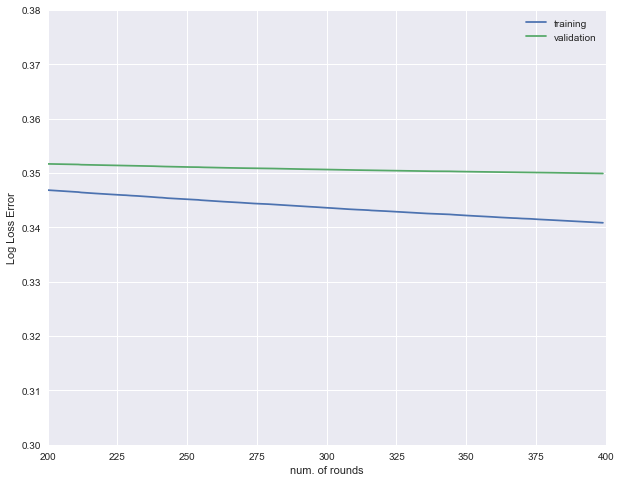

In [39]:
plt.figure(figsize=(10,8))
plt.plot(model_cv['train-logloss-mean'], label='training')
plt.plot(model_cv['test-logloss-mean'], label='validation')
plt.xlim(200, 400)
plt.ylim(0.3, 0.38)
plt.xlabel('num. of rounds')
plt.ylabel('Log Loss Error')
plt.legend()
plt.show()

# Predict and save submission

In [ ]:
# watchlist = [(d_train, 'train'), (d_valid, 'valid')]
# bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

In [40]:
%%time

model_val = bst.predict(xgb.DMatrix(x_valid))

CPU times: user 2.53 s, sys: 8.94 ms, total: 2.54 s
Wall time: 712 ms


In [42]:
from sklearn.metrics import log_loss

print((model_val))
print((np.array(y_valid)))
log_loss(np.array(y_valid), model_val)

[ 0.35639253  0.00058213  0.23379147 ...,  0.00058213  0.04105556
  0.00058213]
[ 0.  0.  0. ...,  0.  0.  0.]


0.34926026801841858

In [43]:
%%time

model_pred = bst.predict(xgb.DMatrix(x_test))

submission = pd.DataFrame()
submission['test_id'] = df_test['test_id']
submission['is_duplicate'] = model_pred
submission.to_csv('simple_xgb.csv', index=False)

In [44]:
submission.head()

,test_id,is_duplicate
0,0,0.036964
1,1,0.348915
2,2,0.301373
3,3,0.000582
4,4,0.127287
